In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
data = loadmat("../data/ex9data1.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X, Xval, yval = data['X'], data['Xval'], data['yval']
print(f"X_shape: {X.shape}, Xval_shape: {Xval.shape}, yval_shape: {yval.shape}")

X_shape: (307, 2), Xval_shape: (307, 2), yval_shape: (307, 1)


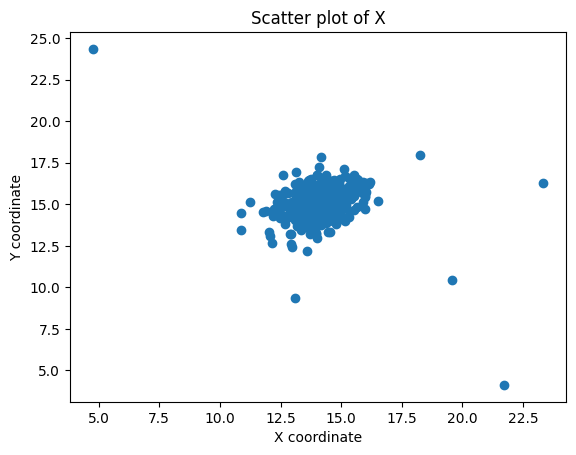

In [4]:
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Scatter plot of X')
plt.show()

### **1. 获取训练集中样本特征的均值和方差**

In [5]:
def calculate_statistics(dataset):
    mean = np.mean(dataset, axis=0)
    variance = np.var(dataset, axis=0)
    std_deviation = np.std(dataset, axis=0)
    covariance_matrix = np.cov(dataset, rowvar=False, ddof=0)
    return mean, variance, std_deviation, covariance_matrix

mean, variance, std_deviation, covariance_matrix = calculate_statistics(X)

print("mean：", mean)
print("variance：", variance)
print("std_deviation：", std_deviation)
print("covariance_matrix：", covariance_matrix)

mean： [14.11222578 14.99771051]
variance： [1.83263141 1.70974533]
std_deviation： [1.35374717 1.3075723 ]
covariance_matrix： [[ 1.83263141 -0.22712233]
 [-0.22712233  1.70974533]]


### **2. 多元正态分布函数**

In [6]:
from scipy.stats import norm
from scipy.stats import multivariate_normal

def joint_pdf(sample, mean, std_deviation):
    pdf1 = norm.pdf(sample[0], mean[0], std_deviation[0])
    pdf2 = norm.pdf(sample[1], mean[1], std_deviation[1])
    return pdf1 * pdf2

def multivariate_normal_pdf(sample, mean, cov):
    if np.linalg.det(cov) == 0:
        raise ValueError("The covariance matrix must be positive definite.")
    pdf_value = multivariate_normal.pdf(sample, mean, cov)
    return pdf_value

### **3. 绘制等高线图**

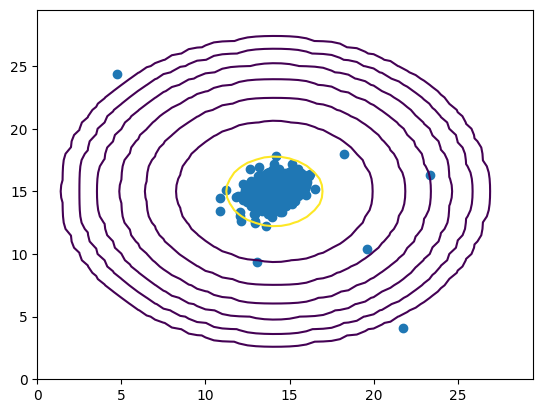

In [7]:
x = np.arange(0, 30, 0.5)
y = np.arange(0, 30, 0.5)
xx, yy = np.meshgrid(x, y)

points = np.column_stack((xx.ravel(), yy.ravel()))

z = np.zeros_like(xx.ravel())
for i in range(len(points)):
    z[i] = joint_pdf(points[i], mean, std_deviation)

zz = z.reshape(xx.shape)

plt.scatter(X[:, 0], X[:, 1])

contour_level = [10 ** h for h in range(-20, 0, 3)]

plt.contour(xx, yy, zz, contour_level)
plt.show()

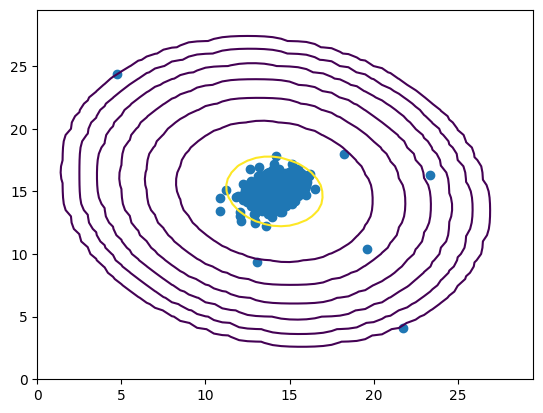

In [8]:
x = np.arange(0, 30, 0.5)
y = np.arange(0, 30, 0.5)
xx, yy = np.meshgrid(x, y)

points = np.column_stack((xx.ravel(), yy.ravel()))

z = np.zeros_like(xx.ravel())
for i in range(len(points)):
    z[i] = multivariate_normal_pdf(points[i], mean, covariance_matrix)

zz = z.reshape(xx.shape)

plt.scatter(X[:, 0], X[:, 1])

contour_level = [10 ** h for h in range(-20, 0, 3)]

plt.contour(xx, yy, zz, contour_level)
plt.show()

In [9]:
p = np.zeros(X.shape[0])
pval = np.zeros(Xval.shape[0])

for i in range(X.shape[0]):
    p[i] = joint_pdf(X[i], mean, std_deviation)

for i in range(Xval.shape[0]):
    pval[i] = joint_pdf(Xval[i], mean, std_deviation)

print(f"min_pval: {min(pval)}, max_pval: {max(pval)}")
cnt1, cnt0 = np.sum(yval == 1), np.sum(yval == 0)
print('Count of positive labels:', cnt1)
print('Count of negative labels:', cnt0)

yval = yval.flatten()

min_pval: 4.513250930309875e-36, max_pval: 0.08990852779269493
Count of positive labels: 9
Count of negative labels: 298


In [10]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    
    step_size = (max(pval) - min(pval)) / 1000
    epsilons = np.arange(min(pval), max(pval), step_size)
    
    for epsilon in epsilons:
        preds = pval < epsilon
        
        tp = np.sum((preds == 1) & (yval == 1))
        fp = np.sum((preds == 1) & (yval == 0))
        fn = np.sum((preds == 0) & (yval == 1))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [11]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

(8.990852779269493e-05, 0.8750000000000001)

In [12]:
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 303, 304, 305, 306]),)

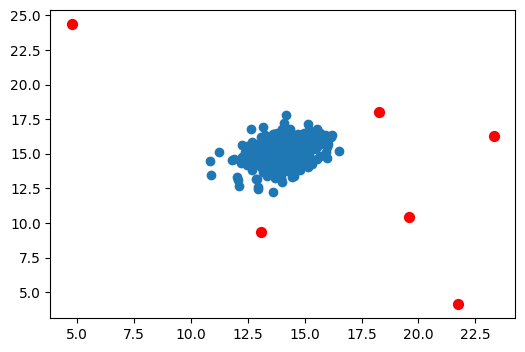

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')
plt.show()